<a href="https://colab.research.google.com/github/Ji-hyun714/Section2_PJ/blob/main/Section2_PJ_%EC%A0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Section 2_Project**

필요한 라이브러리 설치 및 데이터 업로드

In [1]:
!pip install category_encoders 
!pip install xgboost==1.7.2
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached PDPbox-0.2.1-py3-none-any.whl


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from hyperopt import hp
from hyperopt import fmin, tpe, Trials, STATUS_OK
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving netflix daily top 10.csv to netflix daily top 10.csv


In [5]:
df_origin = pd.read_csv('netflix daily top 10.csv')
df = df_origin.copy()  # 원본데이터 저장

In [6]:
df.columns = ['As_of', 'Rank', 'Year_to_Date_Rank', 'Last_Week_Rank', 'Title', 'Type',
       'Netflix_Exclusive', 'Netflix_Release_Date', 'Days_In_Top_10',
       'Viewership_Score']

# **[ 문제 정의 및 데이터 선정 이유 ]**

## **1. 문제 정의** ##

넷플릭스에 종사하는 사람이라고 가정했을 때, 유행하는 Movie/TV Show는 넷플릭스 독점을 할 것인가

넷플릭스 독점여부를 타겟으로 하여 독점여부를 예측하는 분류 모델을 만들고,

분석 후 넷플릭스 독점 여부를 결정하기 위해 모델을 해석하여 어떤 특징을 가지는지 확인한다.

이를 바탕으로 앞으로 어떤 작품들을 넷플릭스 독점으로 해야 보다 많은 이익을 얻을 지 생각해본다.

## **2. 데이터셋 선정** ##

기준일자별로 그 날의 1~10위까지의 데이터가 들어있는 데이터셋으로 선정하였다.

데이터도 필요한 것만 깔끔하게 존재하고, 결측치도 거의 존재하지 않아서 선택하였다.

## **3. Data Description** ##

- `As_of` : 기준 일자

- `Rank` : 순위

- `Year_to_Date_Rank` : 올해 초부터 누적 통계 순위

- `Last_Week_Rank` : 지난 주 순위

- `Title` : 제목

- `Type` : 미디어 타입

- `Netflix_Exclusive` : 넷플릭스 독점 여부

- `Netflix_Release_Date` : 넷플릭스 개봉 날짜

- `Days_In_Top_10` : 탑 10에 머무른 날짜

- `Viewership_Score` : 시청자 점수

## **4. 타겟** ##

: 넷플릭스 독점여부를 나타내는 `Netflix_Exclusive` 컬럼

# **[ 데이터 전처리 ]**

## **1. 결측치 확인** ##

In [7]:
df.isnull().sum()

As_of                      0
Rank                       0
Year_to_Date_Rank          0
Last_Week_Rank             0
Title                      0
Type                       0
Netflix_Exclusive       2501
Netflix_Release_Date       0
Days_In_Top_10             0
Viewership_Score           0
dtype: int64

## **2. 중복값 확인** ##

In [8]:
df.duplicated().sum()

0

## **3. 이상치 확인** ##

In [9]:
df.describe()

,Rank,Days_In_Top_10,Viewership_Score
count,7100.000000,7100.000000,7100.000000
mean,5.500000,24.123662,122.790141
std,2.872484,58.473789,213.861642
min,1.000000,1.000000,1.000000
25%,3.000000,3.000000,19.000000
50%,5.500000,7.000000,50.000000
75%,8.000000,18.000000,128.000000
max,10.000000,428.000000,1474.000000


In [10]:
# Viewership_Score가 100 이상인 값이 있음을 확인 >> 이상치인지 확인 필요

In [11]:
# Viewership_Score가 100 이상인 값의 비율 확인
df.query('Viewership_Score > 100').shape[0] / df.shape[0]

0.3066197183098592

In [12]:
# Viewership_Score가 100 이상인 값 : 총 데이터의 30% 정도를 차지 >> 이상치가 아닌 것으로 판단

In [13]:
# Nailed It! 를 예시로 사용
df.query('Title == "Nailed It!"').sort_values(by='As_of')

,As_of,Rank,Year_to_Date_Rank,Last_Week_Rank,Title,Type,Netflix_Exclusive,Netflix_Release_Date,Days_In_Top_10,Viewership_Score
13,2020-04-02,4,-,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",1,7
24,2020-04-03,5,4,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",2,13
37,2020-04-04,8,5,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",3,16
46,2020-04-05,7,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",4,20
57,2020-04-06,8,7,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",5,23
67,2020-04-07,8,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",6,26
78,2020-04-08,9,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",7,28
88,2020-04-09,9,9,4,Nailed It!,TV Show,Yes,"Mar 9, 2018",8,30
98,2020-04-10,9,9,5,Nailed It!,TV Show,Yes,"Mar 9, 2018",9,32
109,2020-04-11,10,9,8,Nailed It!,TV Show,Yes,"Mar 9, 2018",10,33


In [14]:
# Nailed It! 의 예시를 살폈을 때, Viewership_Score는 감소하지 않고 계속 증가함

# >> Viewership_Score : 평균점수가 아닌, 총 점수임을 확인

## **4. 데이터 타입 확인** ##

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   As_of                 7100 non-null   object
 1   Rank                  7100 non-null   int64 
 2   Year_to_Date_Rank     7100 non-null   object
 3   Last_Week_Rank        7100 non-null   object
 4   Title                 7100 non-null   object
 5   Type                  7100 non-null   object
 6   Netflix_Exclusive     4599 non-null   object
 7   Netflix_Release_Date  7100 non-null   object
 8   Days_In_Top_10        7100 non-null   int64 
 9   Viewership_Score      7100 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 554.8+ KB


### **1. As_of** ###

In [16]:
# 기준 일자인 As_of 컬럼 : int로 데이터타입 변경
df['As_of'] = df['As_of'].str.replace('-', '').astype('int')
df['As_of']

0       20200401
1       20200401
2       20200401
3       20200401
4       20200401
          ...   
7095    20220311
7096    20220311
7097    20220311
7098    20220311
7099    20220311
Name: As_of, Length: 7100, dtype: int64

### **2. Year_to_Date_Rank** ###

In [17]:
df.query('Title == "Nailed It!"').sort_values(by='As_of')  # Nailed It! 를 예시로 사용

,As_of,Rank,Year_to_Date_Rank,Last_Week_Rank,Title,Type,Netflix_Exclusive,Netflix_Release_Date,Days_In_Top_10,Viewership_Score
13,20200402,4,-,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",1,7
24,20200403,5,4,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",2,13
37,20200404,8,5,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",3,16
46,20200405,7,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",4,20
57,20200406,8,7,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",5,23
67,20200407,8,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",6,26
78,20200408,9,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",7,28
88,20200409,9,9,4,Nailed It!,TV Show,Yes,"Mar 9, 2018",8,30
98,20200410,9,9,5,Nailed It!,TV Show,Yes,"Mar 9, 2018",9,32
109,20200411,10,9,8,Nailed It!,TV Show,Yes,"Mar 9, 2018",10,33


In [18]:
# Nailed It! 의 예시를 살폈을 때, 전 날의 데이터가 없는 날은 '-'으로 표시됨 >> 필요 없는 행으로 판단

In [19]:
df.drop(['Year_to_Date_Rank'], axis=1, inplace=True)

### **3. Last_Week_Rank** ###

In [20]:
df.query('Title == "Nailed It!"').sort_values(by='As_of')  # Nailed It! 를 예시로 사용

,As_of,Rank,Last_Week_Rank,Title,Type,Netflix_Exclusive,Netflix_Release_Date,Days_In_Top_10,Viewership_Score
13,20200402,4,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",1,7
24,20200403,5,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",2,13
37,20200404,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",3,16
46,20200405,7,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",4,20
57,20200406,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",5,23
67,20200407,8,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",6,26
78,20200408,9,-,Nailed It!,TV Show,Yes,"Mar 9, 2018",7,28
88,20200409,9,4,Nailed It!,TV Show,Yes,"Mar 9, 2018",8,30
98,20200410,9,5,Nailed It!,TV Show,Yes,"Mar 9, 2018",9,32
109,20200411,10,8,Nailed It!,TV Show,Yes,"Mar 9, 2018",10,33


In [21]:
# Nailed It! 의 예시를 살폈을 때, 전 주의 데이터가 없는 날은 '-'으로 표시됨 >> 필요 없는 행으로 판단

In [22]:
df.drop(['Last_Week_Rank'], axis=1, inplace=True)

### **4. Netflix_Release_Date** ###

In [23]:
# 연도 : 새로운 컬럼("year")에 저장
df['year'] = df['Netflix_Release_Date'].str.extract(r'(\d\d\d\d)')

In [24]:
df['year'].sort_values()

1059    2007
4078    2013
4089    2013
4066    2013
4053    2013
        ... 
6837    2022
6836    2022
6834    2022
6661    2022
6513    2022
Name: year, Length: 7100, dtype: object

In [25]:
# 일 : 새로운 컬럼("date")에 저장
df['date'] = df['Netflix_Release_Date'].str.extract(r'(\d|\d\d)')

In [26]:
df['date'].sort_values()

3549    1
3928    1
3931    1
3933    1
3935    1
       ..
1674    9
6348    9
1921    9
2031    9
3608    9
Name: date, Length: 7100, dtype: object

In [27]:
# 두 자리수로 변경
df['date'] = df['date'].str.pad(2, fillchar='0')
df['date'].sort_values()

3549    01
3928    01
3931    01
3933    01
3935    01
        ..
1674    09
6348    09
1921    09
2031    09
3608    09
Name: date, Length: 7100, dtype: object

In [28]:
# 월 : 새로운 컬럼("month")에 저장
df['month'] = df['Netflix_Release_Date'].str.replace(r'[^a-zA-Z]', '', regex=True)

In [29]:
df['month'].value_counts()

Jun    876
Dec    665
Apr    622
Jul    611
Sep    584
Jan    570
May    570
Oct    567
Feb    531
Aug    520
Mar    494
Nov    490
Name: month, dtype: int64

In [30]:
def month_to_num(x):
  if 'Jan' in x:
    return x.replace('Jan', '01')
  elif 'Feb' in x:
    return x.replace('Feb', '02')
  elif 'Mar' in x:
    return x.replace('Mar', '03')
  elif 'Apr' in x:
    return x.replace('Apr', '04')
  elif 'May' in x:
    return x.replace('May', '05')
  elif 'Jun' in x:
    return x.replace('Jun', '06')
  elif 'Jul' in x:
    return x.replace('Jul', '07')
  elif 'Aug' in x:
    return x.replace('Aug', '08')
  elif 'Sep' in x:
    return x.replace('Sep', '09')
  elif 'Oct' in x:
    return x.replace('Oct', '10')
  elif 'Nov' in x:
    return x.replace('Nov', '11')
  elif 'Dec' in x:
    return x.replace('Dec', '12')

In [31]:
df['month'] = df['month'].apply(month_to_num)
df['month']

0       03
1       07
2       03
3       03
4       03
        ..
7095    03
7096    02
7097    08
7098    03
7099    05
Name: month, Length: 7100, dtype: object

In [32]:
# 열 합친 후, 데이터타입 변경 및 열 삭제
df['Netflix_Release_Date'] = df['year'] + df['month'] + df['date']
df['Netflix_Release_Date'] = df['Netflix_Release_Date'].astype('int')
df.drop(['year', 'month', 'date'], axis=1, inplace=True)
df['Netflix_Release_Date']

0       20200302
1       20170702
2       20190302
3       20200302
4       20200302
          ...   
7095    20220301
7096    20220202
7097    20140801
7098    20220301
7099    20180501
Name: Netflix_Release_Date, Length: 7100, dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   As_of                 7100 non-null   int64 
 1   Rank                  7100 non-null   int64 
 2   Title                 7100 non-null   object
 3   Type                  7100 non-null   object
 4   Netflix_Exclusive     4599 non-null   object
 5   Netflix_Release_Date  7100 non-null   int64 
 6   Days_In_Top_10        7100 non-null   int64 
 7   Viewership_Score      7100 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 443.9+ KB


## **5. 타겟** ##

### **1. 결측치 채우기** ###

넷플릭스 독점여부를 나타내는 `Netflix_Exclusive` 컬럼이 Yes와 NaN 값으로 나뉘어져 있으므로 NaN 값을 No로 바꿔준다.

In [34]:
df['Netflix_Exclusive'].isnull().sum()

2501

In [35]:
df['Netflix_Exclusive'] = df['Netflix_Exclusive'].fillna('No')
df['Netflix_Exclusive'].value_counts()

Yes    4599
No     2501
Name: Netflix_Exclusive, dtype: int64

### **2. 인코딩** ###

`Netflix_Exclusive` 컬럼은 타겟이 될 컬럼이므로 인코딩해준다.

In [36]:
df['Netflix_Exclusive'] = df['Netflix_Exclusive'].replace({'No':0, 'Yes':1})
df

,As_of,Rank,Title,Type,Netflix_Exclusive,Netflix_Release_Date,Days_In_Top_10,Viewership_Score
0,20200401,1,"Tiger King: Murder, Mayhem …",TV Show,1,20200302,9,90
1,20200401,2,Ozark,TV Show,1,20170702,5,45
2,20200401,3,All American,TV Show,0,20190302,9,76
3,20200401,4,Blood Father,Movie,0,20200302,5,30
4,20200401,5,The Platform,Movie,1,20200302,9,55
...,...,...,...,...,...,...,...,...
7095,20220311,6,Worst Roommate Ever,TV Show,1,20220301,10,81
7096,20220311,7,Vikings: Valhalla,TV Show,1,20220202,14,100
7097,20220311,8,Shooter,Movie,0,20140801,3,7
7098,20220311,9,Shrek 2,Movie,0,20220301,10,33


# **[ 가설 설정 ]**

## **가설 1** ##

1. `Rank` 가 높을수록 넷플릭스 독점일 것이다.

## **가설 2** ##

2. `Days_In_Top_10` 이 높을수록 넷플릭스 독점일 것이다.

## **가설 3** ##

3. `Viewership_Score` 가 높을수록 넷플릭스 독점일 것이다.

# **[ EDA 및 시각화 ]** #

### **가설 1 : `Rank` 가 높을수록 넷플릭스 독점일 것이다.** ###

`Rank` 에 따른 넷플릭스 독점 여부 확인

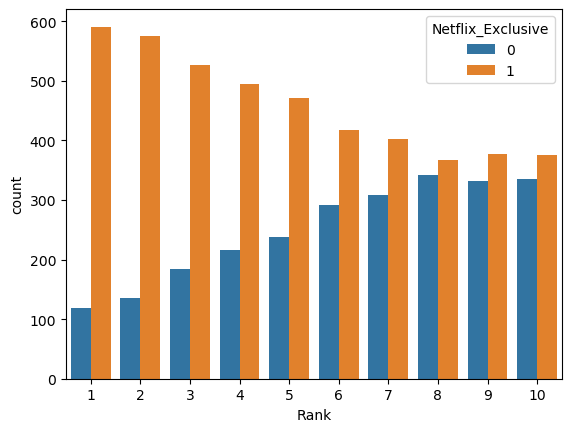

In [37]:
sns.countplot(x = df.Rank, hue = df.Netflix_Exclusive)

plt.show()

In [38]:
# 작품이 높은 순위일 수록, 넷플릭스 독점인 비율이 크다.

# >> 가설 1과 동일

### **가설 2 : `Days_In_Top_10` 이 높을수록 넷플릭스 독점일 것이다.** ###

`Days_In_Top_10` 에 따른 넷플릭스 독점 여부 확인

In [39]:
df.Days_In_Top_10.sort_values()

1687      1
1436      1
1439      1
1448      1
1467      1
       ... 
6674    424
6687    425
6718    426
6959    427
6998    428
Name: Days_In_Top_10, Length: 7100, dtype: int64

In [40]:
a = []

for i in range(len(df.Days_In_Top_10)):
  if df['Days_In_Top_10'].iloc[i] < 10:
    a.append(5)
  elif 10 <= df['Days_In_Top_10'].iloc[i] < 20:
    a.append(10)
  elif 20 <= df['Days_In_Top_10'].iloc[i] < 30:
    a.append(20)
  elif 30 <= df['Days_In_Top_10'].iloc[i] < 40:
    a.append(30)
  elif 40 <= df['Days_In_Top_10'].iloc[i] < 50:
    a.append(40)
  elif 50 <= df['Days_In_Top_10'].iloc[i] < 60:
    a.append(50)
  elif 60 <= df['Days_In_Top_10'].iloc[i] < 70:
    a.append(60)
  elif 70 <= df['Days_In_Top_10'].iloc[i] < 80:
    a.append(70)
  elif 80 <= df['Days_In_Top_10'].iloc[i] < 90:
    a.append(80)
  elif 90 <= df['Days_In_Top_10'].iloc[i] < 100:
    a.append(90)
  elif 100 <= df['Days_In_Top_10'].iloc[i] < 150:
    a.append(100)
  elif 150 <= df['Days_In_Top_10'].iloc[i] < 200:
    a.append(150)
  elif 200 <= df['Days_In_Top_10'].iloc[i] < 250:
    a.append(200)
  elif 250 <= df['Days_In_Top_10'].iloc[i] < 300:
    a.append(250)
  elif 300 <= df['Days_In_Top_10'].iloc[i] < 350:
    a.append(300)
  elif 350 <= df['Days_In_Top_10'].iloc[i] < 400:
    a.append(350)
  else:
    a.append(400)

df2 = df.copy()
df2['Days_In_Top_10_'] = a

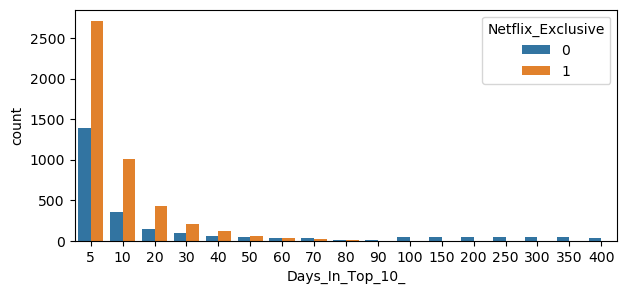

In [41]:
plt.figure(figsize=(7, 3))
sns.countplot(x = df2.Days_In_Top_10_, hue = df.Netflix_Exclusive)

plt.show()

In [42]:
Days_In_Top_10 = pd.DataFrame()

In [43]:
a = df2.query('Days_In_Top_10_ == 5')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
b = df2.query('Days_In_Top_10_ == 10')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
c = df2.query('Days_In_Top_10_ == 20')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
d = df2.query('Days_In_Top_10_ == 30')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
e = df2.query('Days_In_Top_10_ == 40')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
f = df2.query('Days_In_Top_10_ == 50')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
g = df2.query('Days_In_Top_10_ == 60')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
h = df2.query('Days_In_Top_10_ == 70')['Netflix_Exclusive'].value_counts(normalize=True).round(2)
h

0    0.64
1    0.36
Name: Netflix_Exclusive, dtype: float64

In [44]:
Days_In_Top_10['Netflix_Exclusive_ratio'] = a[1], b[1], c[1], d[1], e[1], f[1], g[1], h[1]
Days_In_Top_10.index = [5, 10, 20, 30, 40, 50, 60, 70]
Days_In_Top_10

,Netflix_Exclusive_ratio
5,0.66
10,0.74
20,0.74
30,0.69
40,0.69
50,0.53
60,0.50
70,0.36


In [45]:
# Days_In_Top_10 가 적당할 때(10 ≤ Days_In_Top_10 ≤ 29) 넷플릭스 독점확률이 높으며, 50일 이후는 의미 없음

# >> 가설 2와 반대

### **가설 3 : `Viewership_Score` 가 높을수록 넷플릭스 독점일 것이다.** ###

`Viewership_Score` 에 따른 넷플릭스 독점 여부 확인

In [46]:
df.Viewership_Score .sort_values()

69         1
4099       1
2399       1
5269       1
5639       1
        ... 
6674    1466
6687    1469
6718    1471
6959    1472
6998    1474
Name: Viewership_Score, Length: 7100, dtype: int64

In [47]:
a = []

for i in range(len(df.Viewership_Score)):
  if df['Viewership_Score'].iloc[i] < 25:
    a.append(25)
  elif 25 <= df['Viewership_Score'].iloc[i] < 50:
    a.append(50)
  elif 50 <= df['Viewership_Score'].iloc[i] < 75:
    a.append(75)
  elif 75 <= df['Viewership_Score'].iloc[i] < 100:
    a.append(100)
  elif 100 <= df['Viewership_Score'].iloc[i] < 125:
    a.append(125)
  elif 125 <= df['Viewership_Score'].iloc[i] < 150:
    a.append(150)
  elif 150 <= df['Viewership_Score'].iloc[i] < 175:
    a.append(175)
  elif 175 <= df['Viewership_Score'].iloc[i] < 200:
    a.append(200)
  elif 200 <= df['Viewership_Score'].iloc[i] < 225:
    a.append(225)
  elif 225 <= df['Viewership_Score'].iloc[i] < 250:
    a.append(250)
  elif 250 <= df['Viewership_Score'].iloc[i] < 275:
    a.append(275)
  elif 275 <= df['Viewership_Score'].iloc[i] < 300:
    a.append(300)
  elif 300 <= df['Viewership_Score'].iloc[i] < 400:
    a.append(400)
  elif 400 <= df['Viewership_Score'].iloc[i] < 500:
    a.append(500)
  elif 500 <= df['Viewership_Score'].iloc[i] < 600:
    a.append(600)
  elif 600 <= df['Viewership_Score'].iloc[i] < 700:
    a.append(700)
  elif 700 <= df['Viewership_Score'].iloc[i] < 800:
    a.append(800)
  elif 800 <= df['Viewership_Score'].iloc[i] < 900:
    a.append(900)
  elif 900 <= df['Viewership_Score'].iloc[i] < 1000:
    a.append(1000)
  elif 1000 <= df['Viewership_Score'].iloc[i] < 1100:
    a.append(1100)
  elif 1100 <= df['Viewership_Score'].iloc[i] < 1200:
    a.append(1200)
  elif 1200 <= df['Viewership_Score'].iloc[i] < 1300:
    a.append(1300)
  elif 1300 <= df['Viewership_Score'].iloc[i] < 1400:
    a.append(1400)
  else:
    a.append(1450)

df2['Viewership_Score_'] = a

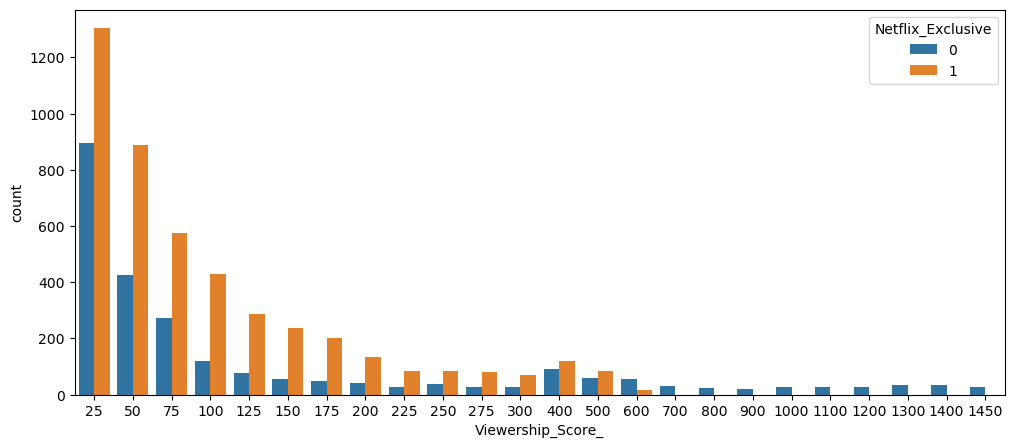

In [48]:
plt.figure(figsize=(12, 5))
sns.countplot(x = df2.Viewership_Score_, hue = df.Netflix_Exclusive)

plt.show()

In [49]:
# Viewership_Score 가 높으면 넷플릭스 독점확률이 높아지지만,
# Viewership_Score 이 300을 넘기면 넷플릭스 독점확률이 낮아지며,
# 일정 점수를 넘어가면 넷플릭스 독점 작품이 존재하지 않음

# >> 일정 점수까진 의미있지만, 일정 점수를 넘어가면 의미 없음

### **각 컬럼의 상관관계 확인** ###

각 컬럼간의 상관관계를 알기 위해 상관계수 이용

(0, 5)

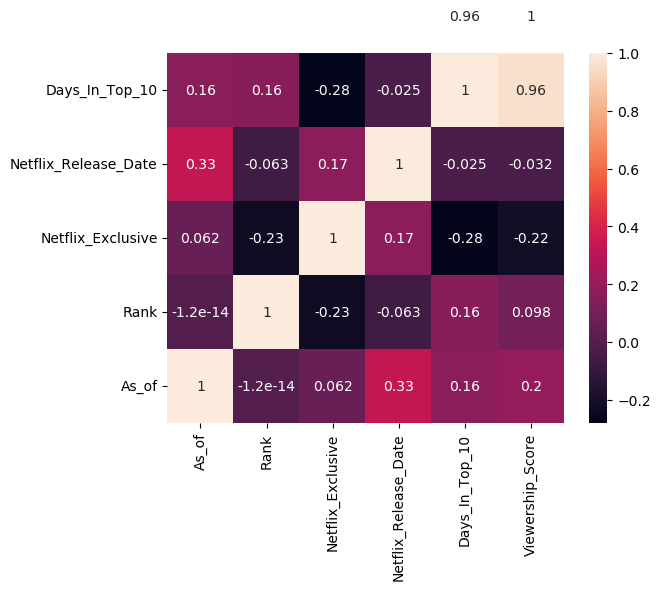

In [50]:
corr = df.corr()
sns.heatmap(corr, annot=True).set_ylim(0,5)

In [51]:
# 높은 상관관계를 나타내는 컬럼 : Days_In_Top_10, Viewership_Score

# 타겟인 Netflix_Exclusive와 높은 상관관계를 가지는 컬럼은 없는 것으로 판단
# >> 정보의 누수(Data Leakage)가 일어나지 않음

#### **상관관계에 있는 컬럼** ####

위에서 높은 상관관계를 나타내는 컬럼인 `Viewership_Score`에 따른 `Days_In_Top_10`의 데이터 분포 확인

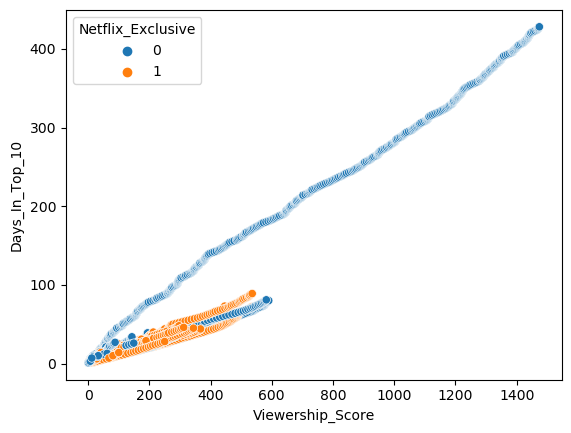

In [52]:
sns.scatterplot(x = df.Viewership_Score, y = df.Days_In_Top_10, hue = df.Netflix_Exclusive)

plt.show()

In [53]:
# 시청자 점수가 높을수록 Top 10에 든 날이 많지만,
# 넷플릭스 독점일 경우, Viewership_Score와 Days_In_Top_10에 한계가 있음을 알 수 있다.


# 예상 1) 데이터가 넷플릭스 오리지널이 아닌 경우,
# 높은 인기를 가진 작품은 가격 문제로 독점하지 못한 것으로 예상

# 예상 2) 데이터가 넷플릭스 오리지널인 경우,
# >> 넷플릭스 사용자만 볼 수 있기 때문에, 시청자 점수 및 Top 10에 한계가 있을 것으로 예상


# **[ 모델링 ]** #

## **1. 데이터 분할** ##

타겟은 넷플릭스 독점여부를 나타내는 컬럼으로 선정

훈련데이터는 2020.04.01 ~ 2021.08.31, 테스트데이터는 2021.09.01 ~ 2022.03.31로 정했으며,

넷플릭스 독점여부 비율을 그대로 유지하며 분할

In [54]:
df['As_of'].sort_values()

0       20200401
1       20200401
2       20200401
3       20200401
4       20200401
          ...   
7094    20220311
7095    20220311
7096    20220311
7097    20220311
7099    20220311
Name: As_of, Length: 7100, dtype: int64

In [55]:
target = "Netflix_Exclusive"

In [56]:
train = df.query('As_of < 20210900')
test = df.query('As_of > 20210900')

In [57]:
def X_y_split(df):
  
    X = df.drop(target, axis=1)
    y = df[target]

    return X, y

In [58]:
X_train, y_train = X_y_split(train.copy())
X_test, y_test = X_y_split(test.copy())

X_train.shape, X_test.shape

((5180, 7), (1920, 7))

In [59]:
df.shape[0] == X_train.shape[0] + X_test.shape[0]

True

## **2. 기준 모델** ##

넷플릭스 독점여부를 판단하는 **분류**문제이기 때문에 XGBClassifier를 이용하여 기준모델을 생성하였으며, 평가지표는 F1 score를 사용하였다.

In [60]:
# 기준모델(XGBClassifier 이용)
pipe = make_pipeline(OrdinalEncoder(),
                     XGBClassifier(random_state=42,
                                   max_depth=3,
                                   learning_rate=0.05))

In [61]:
# 모델 학습
pipe.fit(X_train, y_train)

# 기준 모델 학습 성능
y_pred_base = pipe.predict(X_train)
print(f1_score(y_train, y_pred_base))

0.8612180858650691


In [62]:
print(classification_report(y_train, y_pred_base))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1979
           1       0.79      0.94      0.86      3201

    accuracy                           0.81      5180
   macro avg       0.83      0.77      0.79      5180
weighted avg       0.82      0.81      0.80      5180



In [63]:
# 실제로 넷플릭스 독점이 아닌 것을 아니라고 예측하는 것이 중요하다고 판단

# 따라서 F1 score값 뿐만 아니라 0의 recall값도 주목

## **3. Grid Search** ##

Grid Search는 시간이 오래걸리지만, 모든 요소를 체크할 수 있는 장점이 있기 때문에,

XGBClassifier에서 중요한 하이퍼파라미터인 max_depth와 learning_rate, n_estimators만 우선적으로 조정하였다.

따로 데이터를 교차검증하지 않아도 Grid Search 내에 cv가 존재하기 때문에 선택하였다.

아래의 파라미터를 모두 수행하였지만, 시간관계상 다른 파라미터를 생성하여 진행하였다.

In [64]:
# params = {
#     "xgbclassifier__max_depth": [3, 4, 5, 6, 7, 8, 9],
#     "xgbclassifier__learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
#     "xgbclassifier__n_estimators": [50, 100, 150, 200, 250, 300]
# }

In [65]:
params = {
    "xgbclassifier__max_depth": [3, 4, 5],
    "xgbclassifier__learning_rate": [0.05, 0.1],
    "xgbclassifier__n_estimators": [50, 100]
}

In [66]:
grid_search = GridSearchCV(pipe, param_grid=params, scoring="f1", cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.759 total time=   0.1s
[CV 2/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.737 total time=   0.1s
[CV 3/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=50;, score=0.832 total time=   0.1s
[CV 1/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.765 total time=   0.2s
[CV 2/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.731 total time=   0.2s
[CV 3/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=3, xgbclassifier__n_estimators=100;, score=0.800 total time=   0.2s
[CV 1/3] END xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=4, xgbclassifier__n_est

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['Title', 'Type'],
                                                       mapping=[{'col': 'Title',
                                                                 'data_type': dtype('O'),
                                                                 'mapping': Tiger King: Murder, Mayhem …      1
Ozark                             2
All American                      3
Blood Father                      4
The Platform                      5
                               ... 
Clickbait                       498
Bob Ross: Happy Accidents, …    499
Heâs All That                 500
SAS: Red Notice                 501
NaN                              -2
Length: 502, dtype: int64},
                                                                {'col': 'Type',
                                                                 'data_type...
                                                      max_cat_to_onehot=4,
                                                      max_delta_step=0,
                                                      max_depth=3, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=42, ...))]),
             param_grid={'xgbclassifier__learning_rate': [0.05, 0.1],
                         'xgbclassifier__max_depth': [3, 4, 5],
                         'xgbclassifier__n_estimators': [50, 100]},
             scoring='f1', verbose=3)

In [67]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 f1: ", grid_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 50}
최적 f1:  0.7759798615225334


In [68]:
pipe_grid = make_pipeline(OrdinalEncoder(),
                          XGBClassifier(random_state=42,
                                        n_estimators=50,
                                        max_depth=3,
                                        learning_rate=0.05))

In [69]:
# 모델 학습
pipe_grid.fit(X_train, y_train)

# 기준 모델 학습 성능
y_pred_grid = pipe_grid.predict(X_train)
print(f1_score(y_train, y_pred_grid))

0.8308203070964171


## **4. Bayesian Search** ##

검증하고자 하는 하이퍼파라미터의 범위 내에서, 이전에 탐색한 조합들의 성능을 기반으로 성능이 잘 나오는 조합을 중심으로 확률적으로 탐색하는 방법으로, Bayesian Search 또한 cv가 존재한다.

위의 Grid Search의 하이퍼파라미터 조합에 부가적으로 다른 하이퍼파라미터를 추가하였다.

In [70]:
params = {
    "xgbclassifier__max_depth": hp.quniform("max_depth", 3, 9, 1),
    "xgbclassifier__learning_rate": hp.quniform("learning_rate", 0.05, 0.3, 0.05),
    "xgbclassifier__n_estimators": hp.quniform("n_estimators", 50, 300, 50),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2, 10, 2),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

In [71]:
def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(params["xgbclassifier__max_depth"])
    params["xgbclassifier__n_estimators"] = int(params["xgbclassifier__n_estimators"])
    pipe = make_pipeline(OrdinalEncoder(),
                         XGBClassifier(objective="binary:logistic",
                                       eval_metric="auc",
                                       random_state=42,
                                       n_jobs=-1,
                                       use_label_encoder=False))
    
    pipe = pipe.set_params(**params)
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="f1")
    avg_cv_score = np.mean(score)
    # f1은 클수록 좋은 metric >> -부호를 붙여 반환
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # 실행되는 매 fit의 학습 정보 및 학습 결과가 저장

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=30,
    rstate = np.random.default_rng(2023)
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색

100%|██████████| 30/30 [01:03<00:00,  2.10s/trial, best loss: -0.8137922672012486]


In [72]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 f1: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.821525929288221], 'learning_rate': [0.05], 'max_depth': [4.0], 'min_child_weight': [4.0], 'n_estimators': [100.0]}
최적 f1:  0.8137922672012486


In [73]:
pipe_bayesian = make_pipeline(OrdinalEncoder(),
                              XGBClassifier(random_state=42,
                                            max_depth=4,
                                            learning_rate=0.05,
                                            n_estimators=100,
                                            min_child_weight=4,
                                            colsample_bytree=0.821525929288221))

In [74]:
# 모델 학습
pipe_bayesian.fit(X_train, y_train)

# 기준 모델 학습 성능
y_pred_bayesian = pipe_bayesian.predict(X_train)
print(f1_score(y_train, y_pred_bayesian))

0.8789604321798803


## **5. 모델 선택** ##

실제로 넷플릭스 독점이 아닌 것을 아니라고 예측하는 것이 중요하다고 판단

따라서, 0의 recall값에 주목

In [75]:
# 기준 모델
print(classification_report(y_train, y_pred_base))

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1979
           1       0.79      0.94      0.86      3201

    accuracy                           0.81      5180
   macro avg       0.83      0.77      0.79      5180
weighted avg       0.82      0.81      0.80      5180



In [76]:
# Grid Search
print(classification_report(y_train, y_pred_grid))

              precision    recall  f1-score   support

           0       0.83      0.48      0.61      1979
           1       0.75      0.94      0.83      3201

    accuracy                           0.76      5180
   macro avg       0.79      0.71      0.72      5180
weighted avg       0.78      0.76      0.75      5180



In [77]:
# Bayesian Search
print(classification_report(y_train, y_pred_bayesian))

              precision    recall  f1-score   support

           0       0.88      0.68      0.76      1979
           1       0.83      0.94      0.88      3201

    accuracy                           0.84      5180
   macro avg       0.85      0.81      0.82      5180
weighted avg       0.84      0.84      0.83      5180



In [78]:
# 시행한 모델들 중 Bayesian Search를 이용한 모델이 종합적으로 괜찮은 모델이라고 판단
# >> Bayesian Search을 이용한 모델을 최종 모델로 선택

## **6. 모델 재학습** ##

0의 recall값을 올리기 위해 Class Weight를 사용해 모델을 재학습

### **1. Class Weight 사용** ###

In [79]:
pipe_bayesian_cw = make_pipeline(OrdinalEncoder(),
                                 XGBClassifier(random_state=42,
                                               max_depth=4,
                                               learning_rate=0.05,
                                               n_estimators=100,
                                               min_child_weight=4,
                                               colsample_bytree=0.821525929288221,
                                               scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()))

In [80]:
# 모델 학습
pipe_bayesian_cw.fit(X_train, y_train)

# 기준 모델 학습 성능
y_pred_bayesian_cw = pipe_bayesian_cw.predict(X_train)
print(classification_report(y_train, y_pred_bayesian_cw))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1979
           1       0.88      0.84      0.86      3201

    accuracy                           0.83      5180
   macro avg       0.82      0.83      0.82      5180
weighted avg       0.84      0.83      0.83      5180



### **2. Oversampling + Undersapmling** ###

In [81]:
encoder = OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train.copy())
X_test_encoded = encoder.transform(X_test.copy())

In [82]:
from imblearn.combine import SMOTEENN

X_train_sampled, y_train_sampled = SMOTEENN(random_state=42).fit_resample(X_train_encoded, y_train)

pipe_bayesian_ou = make_pipeline(XGBClassifier(random_state=42,
                                               max_depth=4,
                                               learning_rate=0.05,
                                               n_estimators=100,
                                               min_child_weight=4,
                                               colsample_bytree=0.821525929288221,
                                               scale_pos_weight=(y_train_sampled == 0).sum() / (y_train_sampled == 1).sum()))

In [83]:
# 모델 학습
pipe_bayesian_ou.fit(X_train_sampled, y_train_sampled)

# 기준 모델 학습 성능
y_pred_bayesian_ou = pipe_bayesian_ou.predict(X_train_sampled)
print(classification_report(y_train_sampled, y_pred_bayesian_ou))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2541
           1       0.89      0.90      0.89      2298

    accuracy                           0.90      4839
   macro avg       0.90      0.90      0.90      4839
weighted avg       0.90      0.90      0.90      4839



In [84]:
# 두 가지 모두 성능이 크게 향상되었지만, Oversampling + Undersapmling 모델이 더 많이 향상됨

# >> Oversampling + Undersapmling 모델을 최종모델로 선택

## **7. Test** ##

Oversampling + Undersapmling으로 재학습한 모델으로 평가

In [85]:
pipe_bayesian_ou_test = pipe_bayesian_ou.predict(X_test_encoded)
print(classification_report(y_test, pipe_bayesian_ou_test))

              precision    recall  f1-score   support

           0       0.60      0.89      0.72       522
           1       0.95      0.78      0.86      1398

    accuracy                           0.81      1920
   macro avg       0.78      0.84      0.79      1920
weighted avg       0.86      0.81      0.82      1920



In [86]:
# 정확도는 생각보다 낮았지만, 0의 recall 값이 낮지 않음을 확인

## **8. 모델 시각화** ##

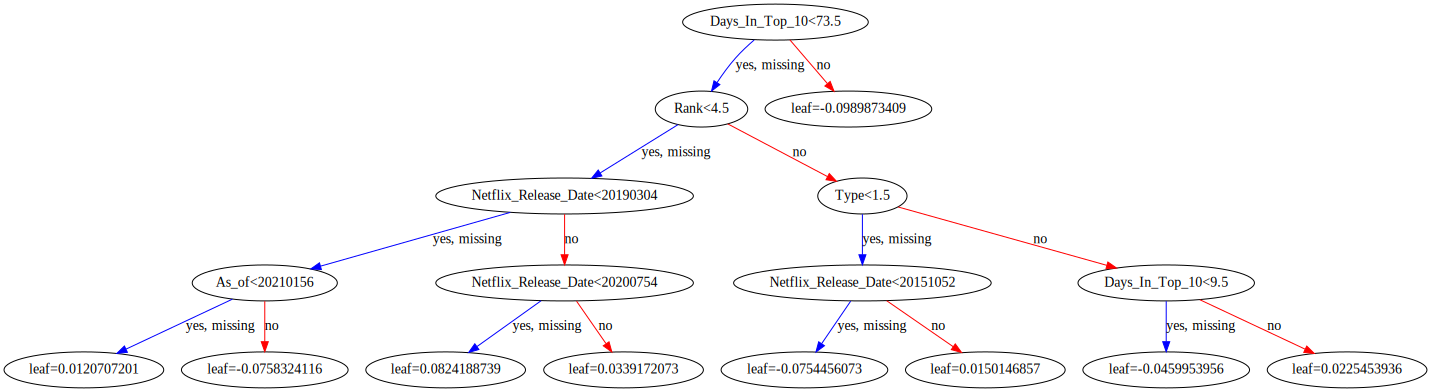

In [87]:
import graphviz
import xgboost as xgb

graph = xgb.to_graphviz(pipe_bayesian_ou.named_steps['xgbclassifier'])
graph

# **[ 모델 해석 ]** #

PDP를 통해 모델의 해당 특성에 대한 전반적인 특징 살피기

In [88]:
# 화질 조정
plt.rcParams["figure.dpi"] = 144

### **1. Rank에 따른 넷플릭스 독점 해석 (가설 1)** ###

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e980a3580>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e980a3f10>})

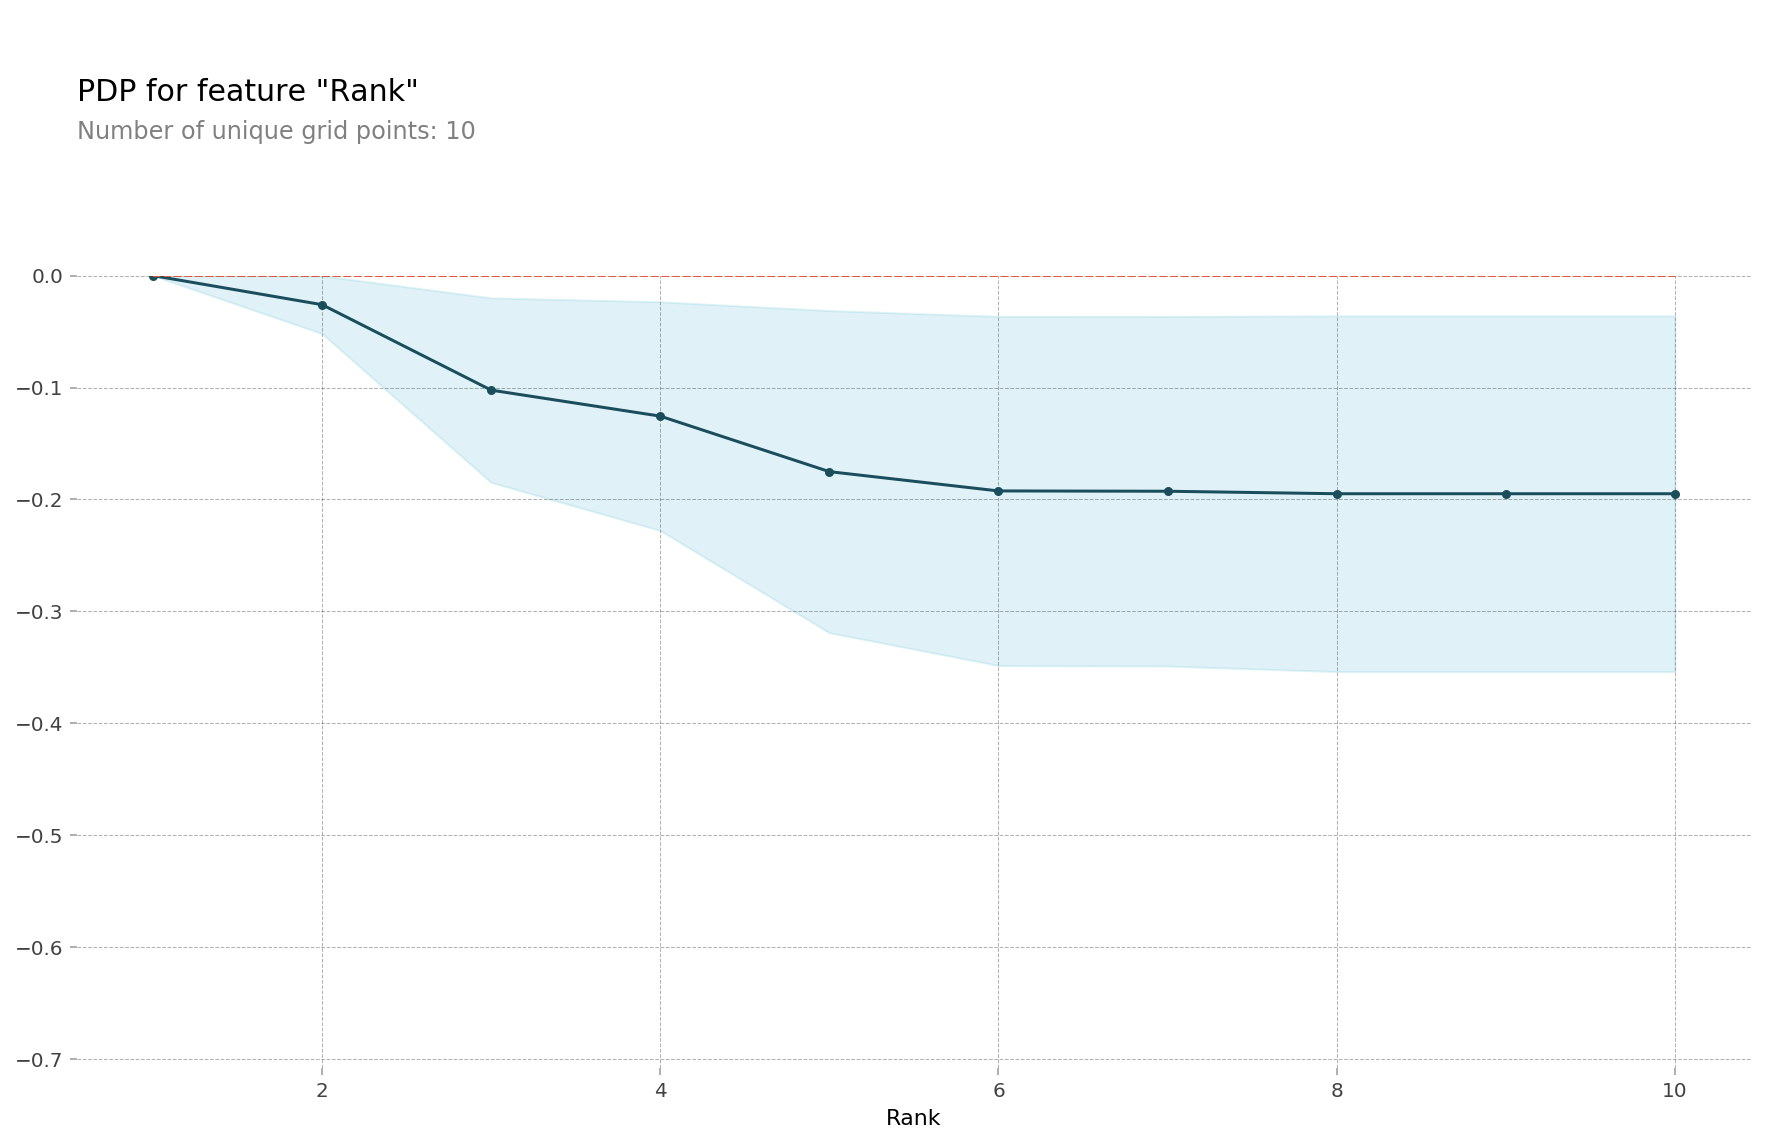

In [89]:
target_feature = "Rank"

isolated = pdp_isolate(model=pipe_bayesian_ou,
                       dataset=X_train_sampled,
                       model_features=X_train_sampled.columns,
                       feature=target_feature,
                       grid_type="percentile",
                       num_grid_points=50)  # 찍히는 점의 개수
pdp_plot(isolated, feature_name=target_feature)

In [90]:
# Rank가 낮아질수록 y의 변화량(넷플릭스 독점 여부)이 감소

### **2. Days_In_Top_10에 따른 넷플릭스 독점 해석 (가설 2)** ###

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e97fe06a0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e97fe0850>})

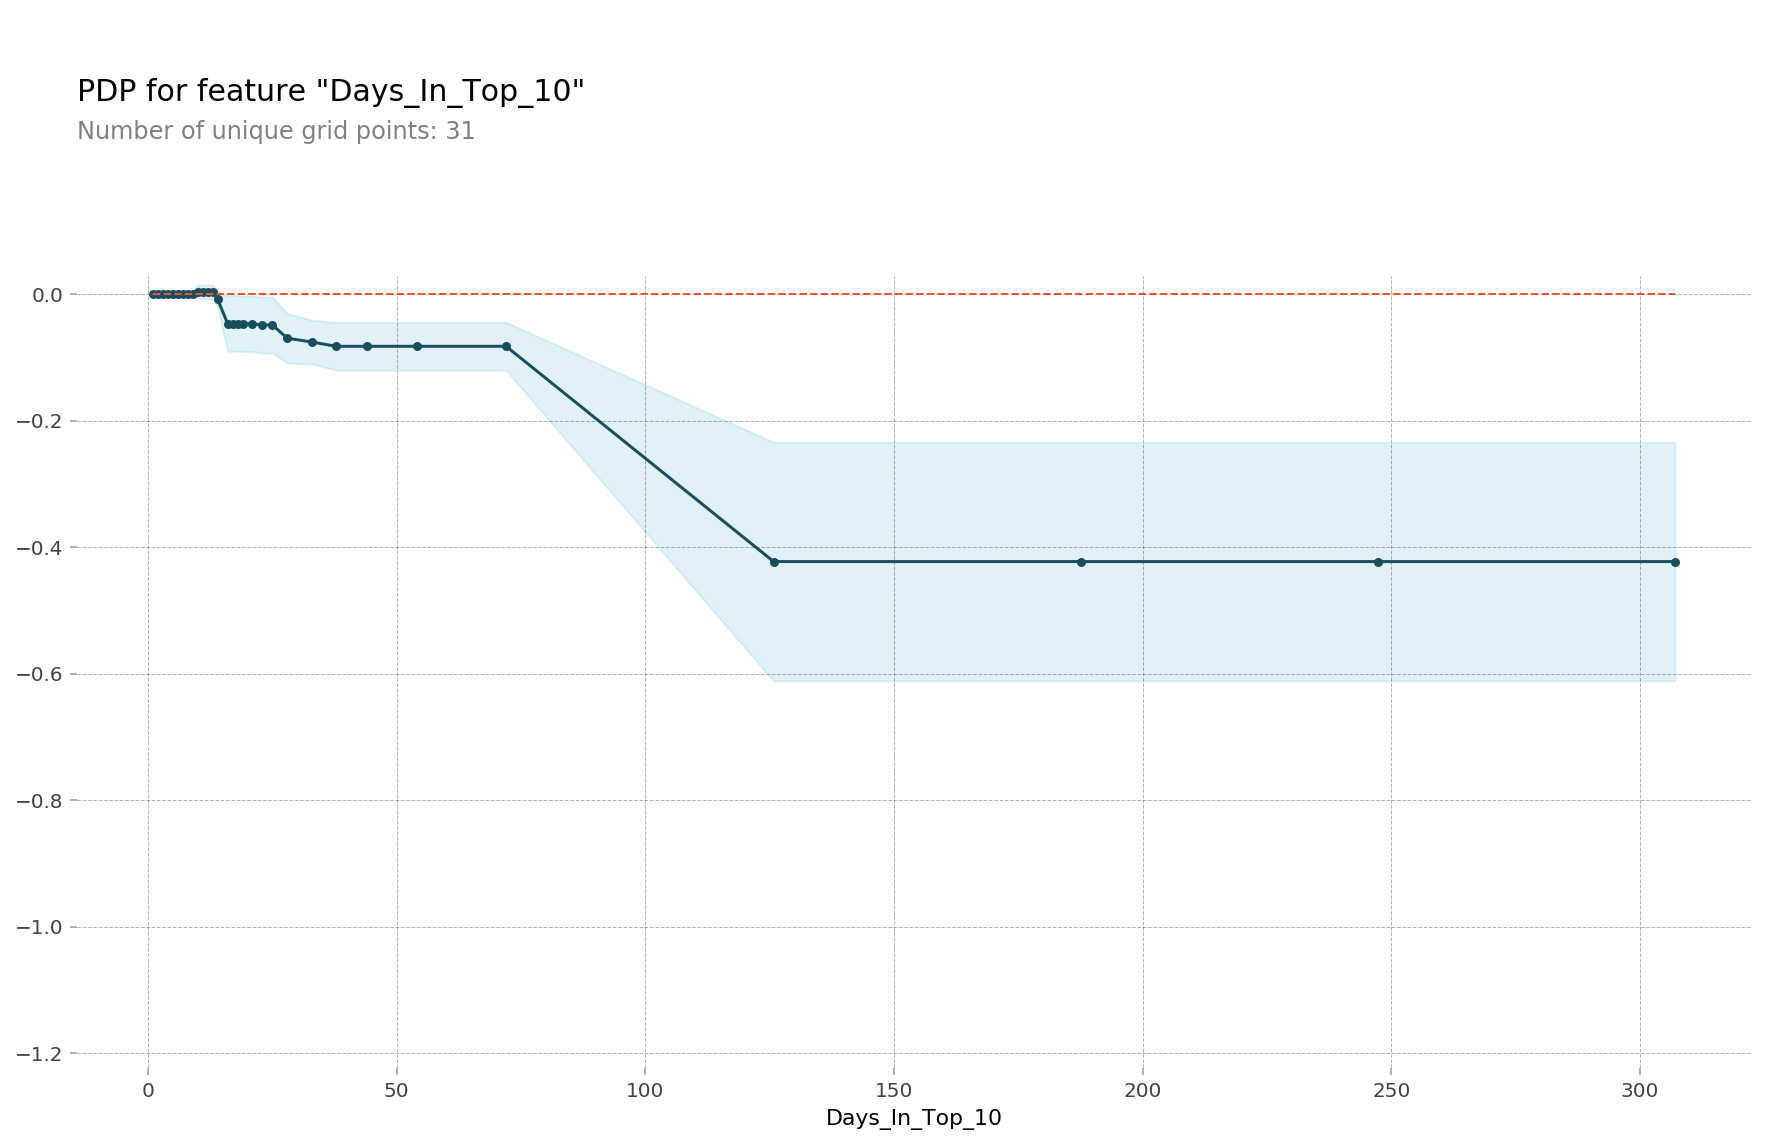

In [91]:
target_feature = "Days_In_Top_10"

isolated = pdp_isolate(model=pipe_bayesian_ou,
                       dataset=X_train_sampled,
                       model_features=X_train_sampled.columns,
                       feature=target_feature,
                       grid_type="percentile",
                       num_grid_points=50)  # 찍히는 점의 개수
pdp_plot(isolated, feature_name=target_feature)

In [92]:
# [시각화] 가설 2에서 본 것과 같이 10 ≤ Days_In_Top_10 ≤ 29일 때 변화량(넷플릭스 독점 여부)이 약간 증가
# 일정 일수를 지나치면 넷플릭스 독점확률은 낮아짐

# Days_In_Top_10 가 적당히 낮을 때 넷플릭스 독점확률이 높음

### **3. Viewership_Score에 따른 넷플릭스 독점 해석 (가설 3)** ###

(<Figure size 2160x1368 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e98512c10>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f3e97f72220>})

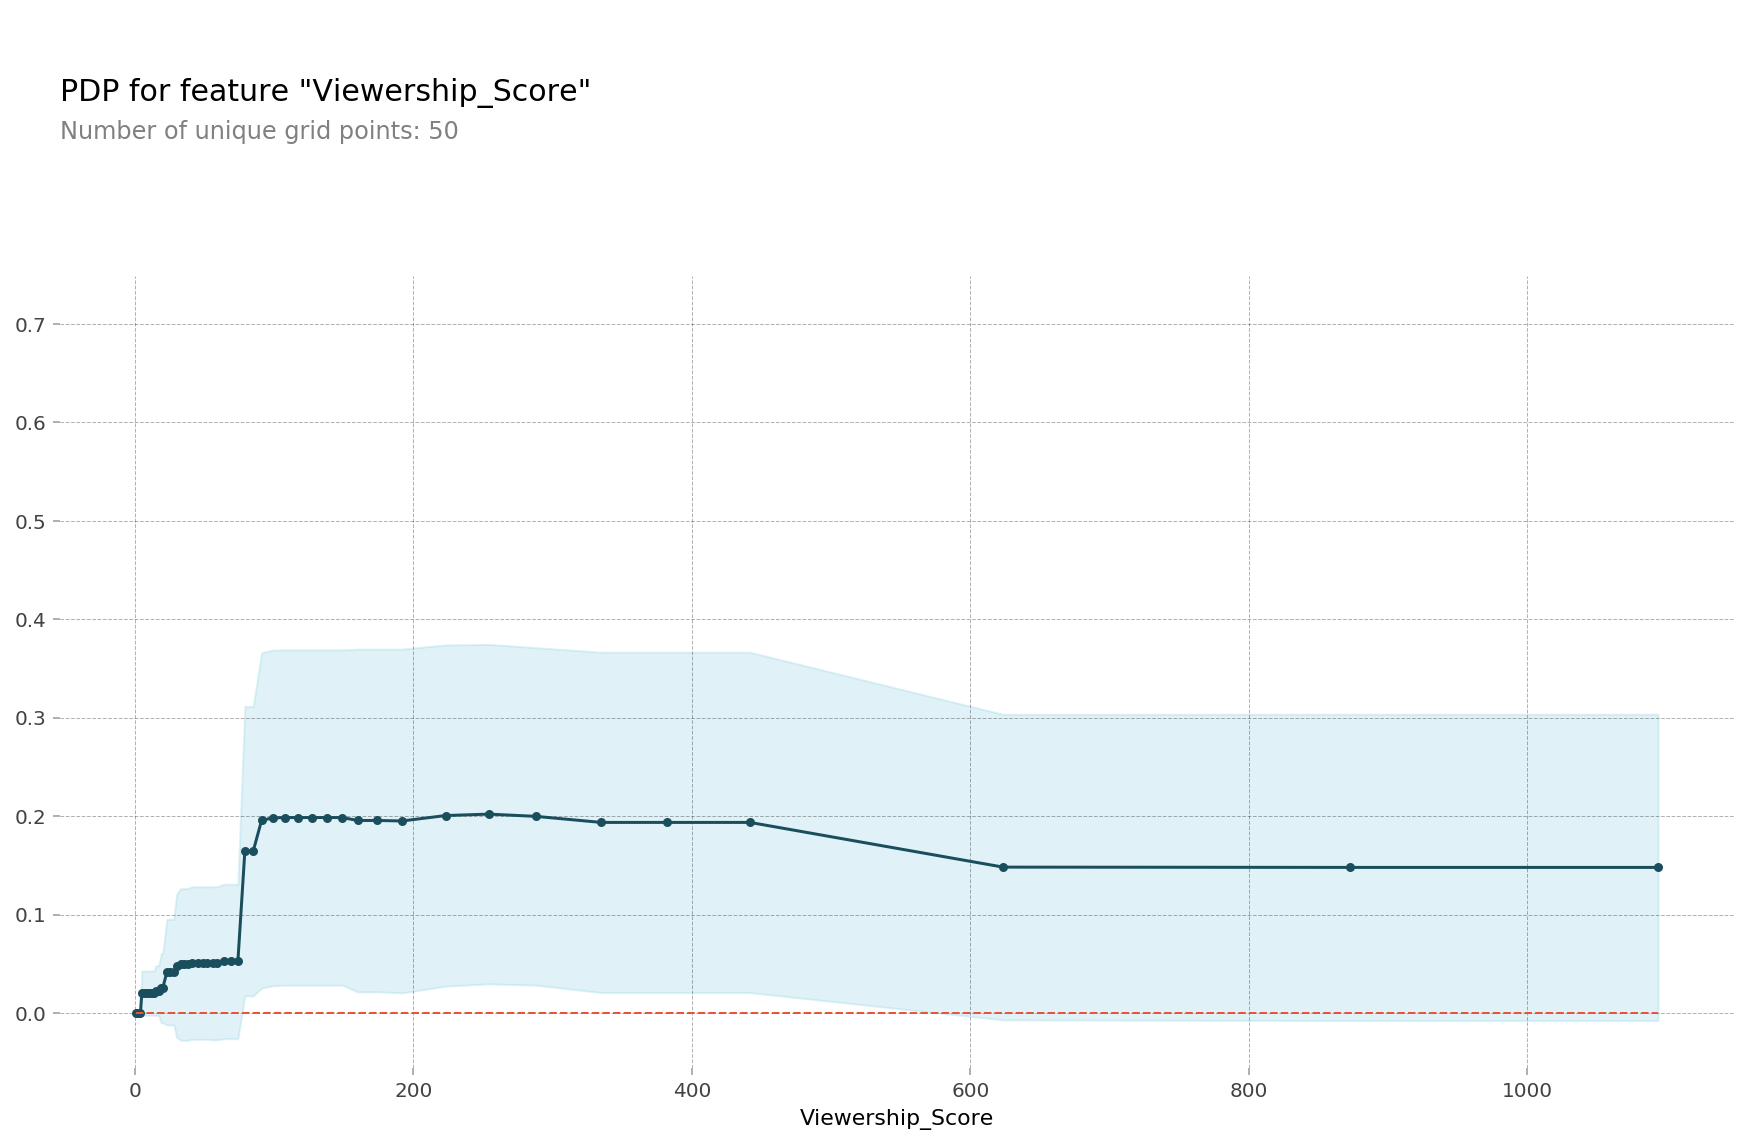

In [93]:
target_feature = "Viewership_Score"

isolated = pdp_isolate(model=pipe_bayesian_ou,
                       dataset=X_train_sampled,
                       model_features=X_train_sampled.columns,
                       feature=target_feature,
                       grid_type="percentile",
                       num_grid_points=50)  # 찍히는 점의 개수
pdp_plot(isolated, feature_name=target_feature)

In [94]:
# Viewership_Score가 80 정도를 넘기면 y의 변화량(넷플릭스 독점 여부)이 급격하게 증가

# >> Viewership_Score가 80 이상 200점 이하일 때, 넷플릭스 독점 비율이 증가할 것으로 예상

In [95]:
df['Netflix_Exclusive'].value_counts(normalize=True)

1    0.647746
0    0.352254
Name: Netflix_Exclusive, dtype: float64

In [96]:
df.query('80 < Viewership_Score < 200')['Netflix_Exclusive'].value_counts(normalize=True)

1    0.796322
0    0.203678
Name: Netflix_Exclusive, dtype: float64

### **4. 종합적 해석** ###

1. `Rank`가 높을수록 넷플릭스 독점을 결정 多

   Rank(일별 순위)가 높으면 넷플릭스 독점일 때, 큰 이익을 볼 수 있다고 생각됨

   하지만 개봉 전에는 Rank를 알 수 없으므로 감독과 작가, 출연진 등과 사용자들의 장르선호도를 고려하여 독점을 결정할 것

2. `Days_In_Top_10`이 10~29일일 때 넷플릭스 독점 多

   Days_In_Top_10(Top_10에 오른 날들)은  30일 이상일 때도 넷플릭스 독점하면 이익이 상승될 것으로 생각됨

   하지만 독점했을 때의 비용과 독점하지 않았을 때의 비용을 생각하여 계산해야 할 것 

3. `Viewership_Score`가 높을수록 넷플릭스 독점 多 (단, 너무 높을 경우 넷플릭스 독점 X)

   Viewership_Score(시청자 점수)가 높으면 인기있다는 증거이므로 Viewership_Score가 높을때 넷플릭스 독점 시, 이익을 볼 수 있다고 생각됨

   하지만 Viewership_Score가 너무 높은 경우는 많은 사용자들이 점수를 준 오래된 작품일 수도 있으므로, 출시 날짜를 고려하도록 할 것